In [243]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from scipy.fft import fft, fftfreq, fftshift

In [1]:
8//2*2+ 1

9

In [244]:
def build_dataset(df, freq):
    T = df["dt"].mean()
    N = int(np.ceil(1/freq/T*4))
    
    data = {}
    data["freqs"] = []
    for n in range(df.shape[0]//N):
        data["freqs"].extend(fftshift(fftfreq(N, T)))
    for col in ["x", "y", "fy", "fx"]:
        data[col + "f"] = []
        for n in range(df.shape[0]//N):
            data[col + "f"].extend(fftshift(fft(df[col].iloc[N*n:N*(n+1)].values)))
            
    return pd.DataFrame(data)

def prepare_frequency_domain_data(filename):
    freq = int(filename.split("Hz")[0].split("_")[-1])
    df = load_amb_sin_data(filename)
    def to_seconds(x):
        try:
            return x.delta*1e-9
        except:
            return np.nan
    
    df["dt"] = (df["datetime"] - df["datetime"].shift()).apply(to_seconds)
    df["t"]  = df["dt"].cumsum()

    T = df["dt"].mean()

    N = int(np.ceil(1/21/T*4))


    df["x"] = (df["ax"] + df["bx"])/2
    #df["x"] = df["ax"]
    df["y"] = (df["ay"] + df["by"])/2
    #df["y"] = df["ay"]
    df['fx'] = df["e_ax"] + df["e_bx"]
    #df["fx"] = df["f_ax"]
    df['fy'] = df["e_ay"] + df["e_by"]
    #df["fx"] = df["f_ay"]
    df = df[["datetime", "x", "y", "fx", "fy", "dt", "t"]]
    
    print(freq)
    
    data = build_dataset(df, freq=freq)
    data = data[np.abs(data["freqs"]) < freq*4]
    return data
    

In [245]:
df = prepare_frequency_domain_data(filename="amb_sin/sine_fx_21Hz_0RPM.txt")
df = pd.concat([df, prepare_frequency_domain_data(filename="amb_sin/sine_fy_21Hz_0RPM.txt")], ignore_index=True)

21
21


In [246]:
df

,freqs,xf,yf,fyf,fxf
0,-83.934430,-0.000012+0.000287j,0.000070+0.000091j,0.000654+0.009015j,-0.459025-0.194317j
1,-78.688528,0.000092+0.000074j,0.000022+0.000015j,0.002764+0.000683j,0.200401+0.037337j
2,-73.442626,0.000047-0.000043j,-0.000032+0.000035j,-0.000733+0.000412j,0.288966+0.120774j
3,-68.196724,0.000010+0.000110j,-0.000035+0.000095j,-0.000283+0.003945j,0.364460+0.132045j
4,-62.950823,0.000323+0.000234j,0.000020-0.000028j,-0.005941+0.000477j,-4.837612-4.580778j
...,...,...,...,...,...
4285,62.950824,0.000329-0.000111j,0.000413+0.000186j,0.286063-0.139915j,0.193142-0.036845j
4286,68.196726,-0.000043+0.000022j,0.000025+0.000102j,0.225995-0.113927j,0.067731-0.022600j
4287,73.442628,0.000168+0.000124j,0.000020+0.000003j,0.193891-0.090667j,0.038902+0.008111j
4288,78.688530,-0.000051+0.000055j,-0.000084-0.000019j,0.167305-0.099419j,0.013886+0.001104j


(-30.0, 30.0)

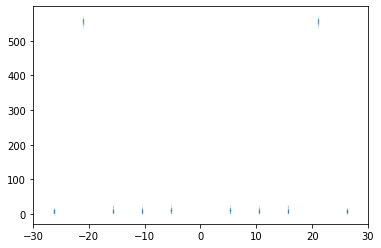

In [247]:
plt.scatter(data["freqs"], np.abs(data["fx_f"]), s=0.1, alpha=0.1)
plt.xlim((-30, 30))

In [248]:
q = df[["xf", "yf"]].values
f = df[["fxf", "fyf"]].values
freqs = df[["freqs"]].values
freqs

array([[-83.93443008],
       [-78.6885282 ],
       [-73.44262632],
       ...,
       [ 73.442628  ],
       [ 78.68853   ],
       [ 83.934432  ]])

In [249]:
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
import jax
%load_ext autoreload
%autoreload 2
from models.frequency_domain import mse, initialize_params, get_batch_forward_pass, get_loss_function, train
from tqdm import tqdm

from utils import Shuffler

rng = random.PRNGKey(20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
mass = [[1, 0], [0, 1]]
def forward_pass(params, q, f, freqs, mass=jnp.array(mass)):
    """
    Um forward pass estima a força no dominio da frequencia

    """
    q = q.reshape((-1, 1))
    M = mass
    C = params[1]
    K = params[0]
    w = np.pi*2*freqs
    return jnp.squeeze(jax.lax.complex(K - jnp.square(freqs)*M, freqs*C) @ q)

batch_forward_pass = get_batch_forward_pass(mass=mass)
params = initialize_params(rng, dims=2, scale=10)
loss = get_loss_function(batch_forward_pass)


In [251]:
params

[DeviceArray([[-6.630825, -5.782476],
              [ 2.076413,  9.427113]], dtype=float32),
 DeviceArray([[-14.662489 ,  -8.464476 ],
              [  6.2902365,   2.6404383]], dtype=float32)]

In [252]:
batch_forward_pass(params, q, freqs)

DeviceArray([[ 0.8654575 -5.052758j  , -1.4943584 -1.5667588j ],
             [-1.4365449 -1.4991926j , -0.4487772 -0.1846811j ],
             [-0.86177856+0.7021049j ,  0.5794474 -0.5799284j ],
             ...,
             [-2.6800263 -2.5105615j , -0.44447947+0.09571959j],
             [ 0.96622336-0.7678224j ,  1.4205734 +0.25688124j],
             [ 2.400355  -3.487595j  ,  5.322443  -1.7554321j ]],            dtype=complex64)

In [253]:
loss(params, q, freqs, f)

DeviceArray(60.77021, dtype=float32)

In [235]:
k = jnp.array([[4300., 430.],
    [-430., 4300.]])
c = jnp.array([[43., 0.],
    [0., 43.]])
params = [k,c]

In [236]:
batch_forward_pass(params, q, freqs)

DeviceArray([[-1.4400254 -3.7903752j , -1.4332309 -0.9159295j ],
             [-1.6157897 -0.44925088j, -0.4146732 -0.10992476j],
             [-0.38184705+0.8512217j ,  0.20017074-0.6202172j ],
             ...,
             [-1.024306  +2.5465708j , -0.20100167+1.3353834j ],
             [ 1.4826986 +0.6869076j ,  0.3033012 -0.14847201j],
             [ 3.3158224 +2.2142584j ,  0.68980384+2.411178j  ]],            dtype=complex64)

In [237]:
f

array([[-0.45902468-1.94316794e-01j,  0.00065408+9.01456255e-03j],
       [ 0.20040137+3.73365873e-02j,  0.00276433+6.82619873e-04j],
       [ 0.28896563+1.20773961e-01j, -0.0007331 +4.11547884e-04j],
       ...,
       [-0.04232664+8.01457068e-01j,  0.00201222+3.34774433e-03j],
       [-0.03414947+6.95772507e-01j,  0.00817579-3.61335352e-03j],
       [-0.54447249+1.10947259e+00j, -0.00109538+8.30929569e-04j]])

In [238]:
loss(params, q, freqs, f)

DeviceArray(62.9274, dtype=float32)

In [254]:
def callback(y_pred, y_true):
    
    plt.figure(figsize=(10, 8))
    #plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred))[100:600], linestyle="dotted")
    #plt.plot(shuffler.undo_shuffle(np.squeeze(y_true))[100:600])
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.show()


train(params, q, freqs, f, batch_size=2, optimizer=adam, step_size=1e-1, epochs=40, callback=None, batch_forward_pass=batch_forward_pass)

  0%|          | 1/2145 [00:00<04:20,  8.22it/s]

Epoch 0


  1%|          | 19/2145 [00:00<00:11, 182.12it/s]

Epoch 0 , mean error: 60.449078 params: [DeviceArray([[ 25.336954, -45.61878 ],
             [ 24.418505,  84.82997 ]], dtype=float32), DeviceArray([[-14.003175 ,  -1.1942002],
             [  2.0448642,  -6.2918577]], dtype=float32)]
Epoch 1


  1%|          | 18/2145 [00:00<00:11, 178.22it/s]

Epoch 1 , mean error: 60.379925 params: [DeviceArray([[ 48.311703, -61.57118 ],
             [ 42.12625 , 114.68894 ]], dtype=float32), DeviceArray([[-13.22573   ,  -0.93739504],
             [  1.5104514 ,  -6.1215672 ]], dtype=float32)]
Epoch 2


  1%|          | 17/2145 [00:00<00:12, 164.07it/s]

Epoch 2 , mean error: 60.337597 params: [DeviceArray([[ 70.86241, -77.20174],
             [ 59.93472, 143.67873]], dtype=float32), DeviceArray([[-12.497761  ,  -0.87415063],
             [  1.2357031 ,  -5.9207096 ]], dtype=float32)]
Epoch 3


  1%|          | 18/2145 [00:00<00:12, 171.16it/s]

Epoch 3 , mean error: 60.296925 params: [DeviceArray([[ 93.36921, -92.79733],
             [ 77.81395, 172.58809]], dtype=float32), DeviceArray([[-11.811609  ,  -0.83151627],
             [  1.0792483 ,  -5.707452  ]], dtype=float32)]
Epoch 4


 72%|███████▏  | 1550/2145 [00:09<00:03, 168.93it/s]


KeyboardInterrupt: 